<a href="https://colab.research.google.com/github/Mrutyunjay01/Tensorflow_in_practice/blob/master/Sequence%2C%20Time%20Series%20Analysis/Create_and_predict_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


In [0]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [0]:
def trend(time, slope=0):
  return time * slope

In [0]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                  np.cos(season_time * 7 * np.pi),
                  1./np.exp(5 * season_time))

In [0]:
def seasonability(time, period, amp=1, phase=0):
  """ Repeats the same pattern over each period."""
  season_time = ((time+phase)%period)/period
  return amp * seasonal_pattern(season_time=season_time)

In [0]:
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)

  return rnd.randn(len(time)) * noise_level

In [0]:
# define the parameters for the synthetic time series data
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

In [0]:
# create the series
series = baseline + trend(time, slope=slope) + seasonability(time, period=365, amp=amplitude)

# add some noise 
series += noise(time, noise_level=noise_level, seed=42)

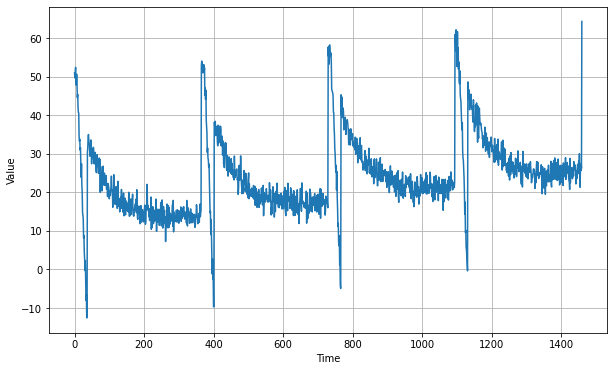

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = int(len(series) * 0.755)# YOUR CODE HERE
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

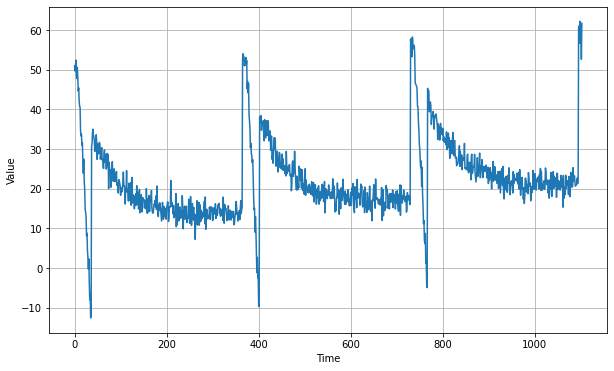

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

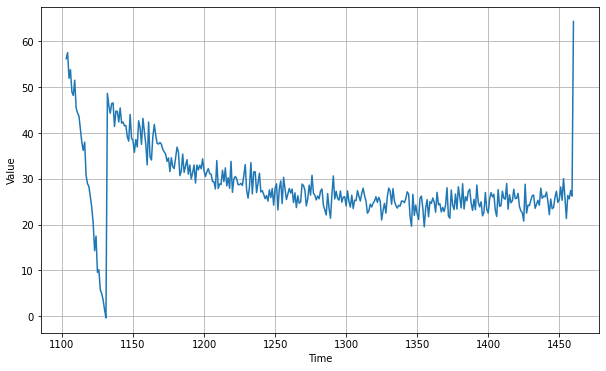

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()


# Naive Forecast

In [0]:
naive_forecast = series[split_time-1: -1]

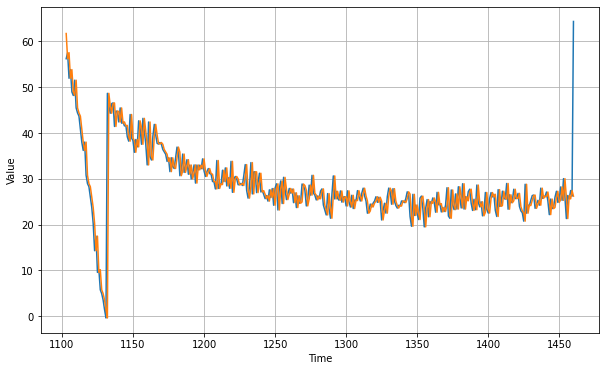

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

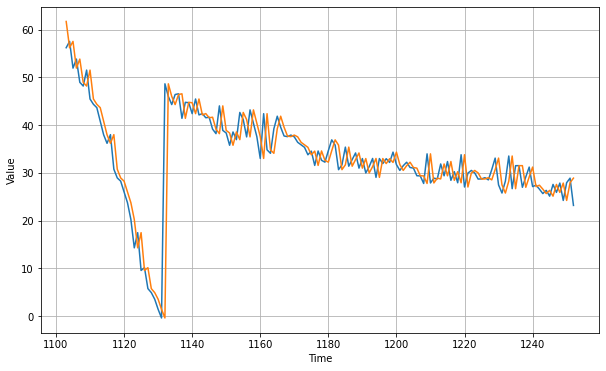

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)

In [18]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

19.30707
2.571906


We got our baseline. Let's improve.

In [0]:
def moving_average(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time : time+window_size].mean())

  return forecast

In [0]:
moving_avg = moving_average(series, window_size=30)[split_time-30: ]

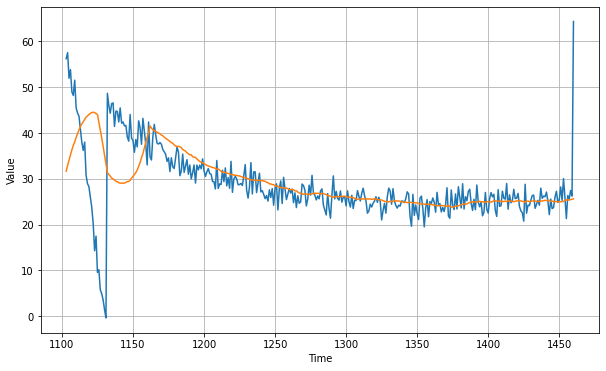

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
plt.show()

In [25]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

58.97187
4.094251


As expected, worse than naive forecast.  

Let's analyse with differencing the series.

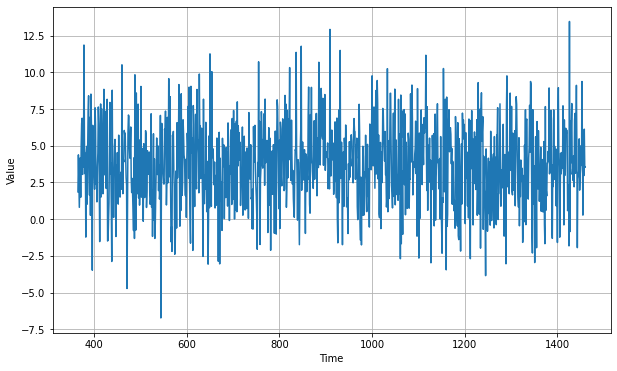

In [27]:
diff_series = series[365: ] - series[:-365]
diff_time = time[365: ]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series)
plt.show()

In [0]:
diff_moving_avg_forecast = moving_average(diff_series, window_size=50)[split_time-365-50:]

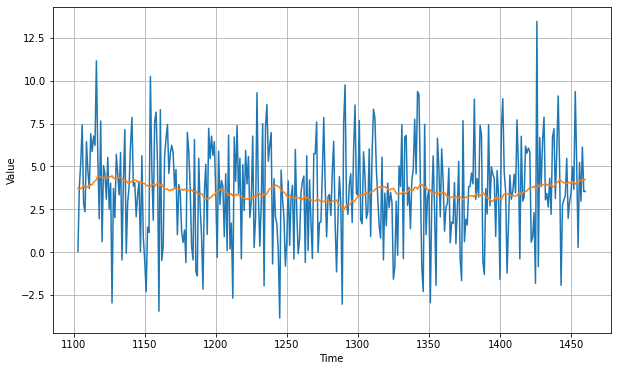

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time-365: ])
plot_series(time_valid, diff_moving_avg_forecast)

Bring back the seasonality and trend by adding back the series values past period values from validation set.

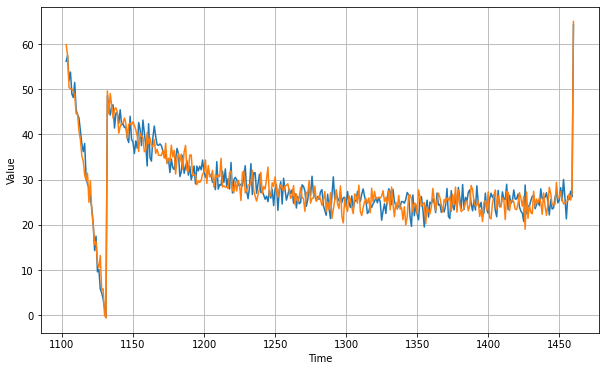

In [33]:
diff_moving_avg_forecast_past = diff_moving_avg_forecast + series[split_time-365: -365]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_forecast_past)

In [35]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_forecast_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_forecast_past).numpy())

8.435395
2.3199332


We can see an improved score, hence let's remove the noise and forecast again.

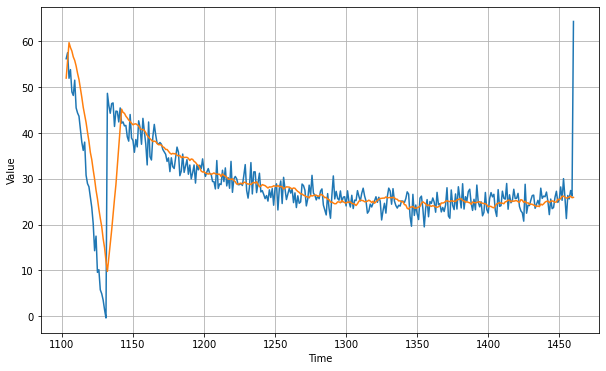

In [49]:
diffSmooth = np.array(diff_moving_avg_forecast) + np.array(moving_average(series[split_time-365-10:-365], 10))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diffSmooth)
plt.show()

In [48]:
a = [1, 2, 3]
b = [3, 4, 5]
np.array(a) + np.array(b)

array([4, 6, 8])

In [50]:
print(keras.metrics.mean_squared_error(x_valid, diffSmooth).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diffSmooth).numpy())

32.807
3.0581214
